@dataset{
    dataset,
    author = {Timilsina, Bimal},
    year = {2021},
    month = {08},
    pages = {},
    title = {News Article Category Dataset},
}

In [1]:
import pandas as pd

In [2]:
df = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)

In [3]:
df['title']=df['headline']
display(df)

,link,headline,category,short_description,authors,date,title
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li..."
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...
...,...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28,Maria Sharapova Stunned By Victoria Azarenka I...
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28,"Giants Over Patriots, Jets Over Colts Among M..."
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28,Aldon Smith Arrested: 49ers Linebacker Busted ...


In [4]:
df['category'] = df['category'].astype('category')

In [5]:
from sklearn.model_selection import train_test_split

x = df.drop('category', axis=1)
y = df['category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

def identity_tokenizer(t):
    return t

model = make_pipeline(TfidfVectorizer(stop_words="english", lowercase=True), MultinomialNB())

model.fit(x_train['title'], y_train)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [7]:
labels = model.predict(x_test['title'])

In [8]:
display(y_test)
display(labels)

161513     HOME & LIVING
45642           POLITICS
19168           POLITICS
123550    HEALTHY LIVING
161699      QUEER VOICES
               ...      
63907      THE WORLDPOST
127547     ENTERTAINMENT
203678       ENVIRONMENT
46617           POLITICS
153610      FOOD & DRINK
Name: category, Length: 41906, dtype: category
Categories (42, object): ['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', ..., 'WELLNESS', 'WOMEN', 'WORLD NEWS', 'WORLDPOST']

array(['HOME & LIVING', 'POLITICS', 'POLITICS', ..., 'POLITICS',
       'POLITICS', 'WELLNESS'], dtype='<U14')

In [9]:
from sklearn.metrics import confusion_matrix, f1_score

category_names = pd.unique(y_train).sort_values()
mat = confusion_matrix(y_test, labels, labels=category_names)
f1_score_result = f1_score(y_test, labels, average='micro')

0.42053643869612944
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  1  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 28  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  0]]


Text(109.44999999999996, 0.5, 'predicted label')

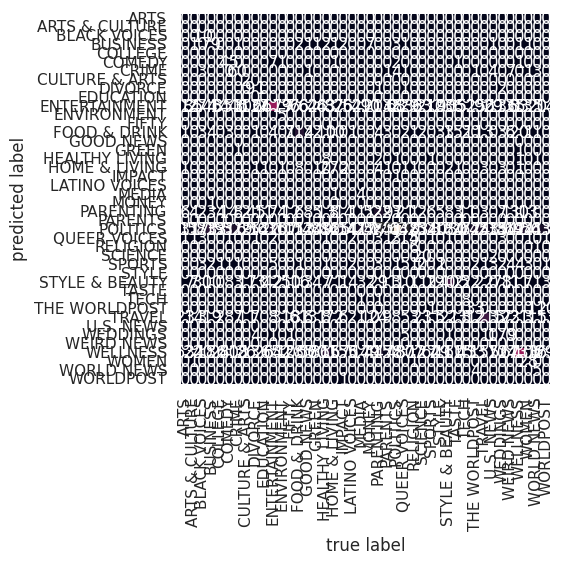

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

print(f1_score_result)

print(mat)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=category_names, yticklabels=category_names)
plt.xlabel('true label')
plt.ylabel('predicted label')